In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from eo_utils import geojson_to_shapely, load_ssm
from pathlib import Path
from rasterstats import zonal_stats
from shapely import Polygon, MultiPolygon
from datetime import datetime
import pandas as pd
from scipy.stats import linregress
import matplotlib

In [2]:
matplotlib.colors.cnames['grey']

'#808080'

In [3]:
igram = "/data/tapas/pearse/malawi/sentinel1/kasungu_stack/merged/interferograms/20230114_20230126/filt_fine.int"
ds = gdal.Open(igram , gdal.GA_ReadOnly)
geocoded_igram = "/data/tapas/pearse/malawi/sentinel1/kasungu_stack/merged/interferograms/20230114_20230126/filt_fine.int.geo"
gds = gdal.Open(geocoded_igram , gdal.GA_ReadOnly)
geocoded_igram1 = "/data/tapas/pearse/malawi/sentinel1/kasungu_stack/merged/interferograms/20230114_20230126/geo_filt_fine.int"
gds1 = gdal.Open(geocoded_igram1 , gdal.GA_ReadOnly)
coherence = "/data/tapas/pearse/malawi/sentinel1/kasungu_stack/merged/interferograms/20230114_20230126/fine.cor"
coherence_ds = gdal.Open(coherence, gdal.GA_ReadOnly)
geocoded_coherence = "/data/tapas/pearse/malawi/sentinel1/kasungu_stack/merged/interferograms/20230114_20230126/geo_filt_fine.cor"
geocoded_coherence_ds = gdal.Open(geocoded_coherence, gdal.GA_ReadOnly)
lat = "/data/tapas/pearse/malawi/sentinel1/kasungu_stack/merged/geom_reference/lat.rdr"
lon = "/data/tapas/pearse/malawi/sentinel1/kasungu_stack/merged/geom_reference/lon.rdr"
lat_ds = gdal.Open(lat, gdal.GA_ReadOnly)
lon_ds = gdal.Open(lon, gdal.GA_ReadOnly)

/data/tapas/pearse/miniconda3/envs/gis/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
geocoded_coherence_ds.GetGeoTransform()

(33.2, 0.0001, -0.0, -12.85, -0.0, -0.0001)

In [5]:
nodata = 0 +0j

In [6]:
igram_arr = ds.ReadAsArray()
geo_igram_arr = gds.ReadAsArray()
geo_igram_arr1 = gds1.ReadAsArray()
lat_arr = lat_ds.ReadAsArray()
lon_arr = lon_ds.ReadAsArray()
coherence_array = coherence_ds.ReadAsArray()
geocoded_coherence_array = geocoded_coherence_ds.ReadAsArray()

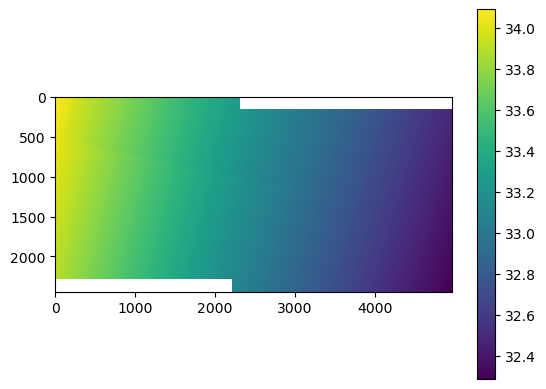

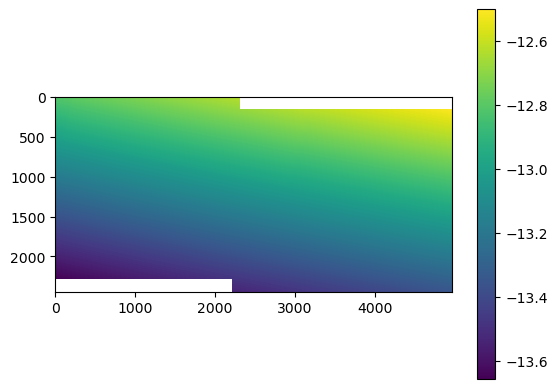

In [7]:
# %matplotlib widget
lon_arr = np.ma.masked_where(lon_arr == 0, lon_arr)
plt.imshow(lon_arr)
plt.colorbar()
plt.figure()
lat_arr = np.ma.masked_where(lat_arr == 0, lat_arr)
plt.imshow(lat_arr)
plt.colorbar()


In [8]:
lat_arr.shape, lon_arr.shape, coherence_array.shape

((2442, 4969), (2442, 4969), (2, 2442, 4969))

In [9]:
np.max(coherence_array, axis=(1,2))

array([1.2369044e+03, 9.8300397e-01], dtype=float32)

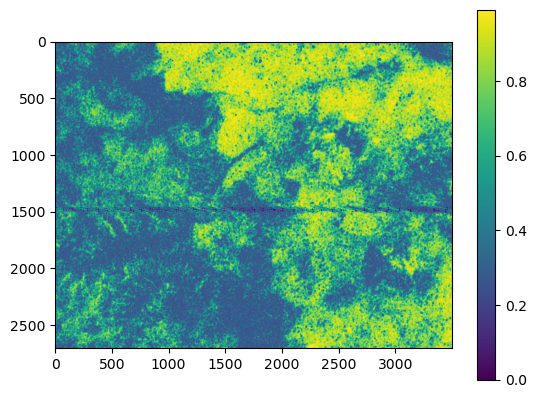

In [10]:
plt.imshow(geocoded_coherence_array)
plt.colorbar()

In [11]:
geo_igram_mask = np.ma.masked_values(geo_igram_arr, nodata)

# geo_igrammask = np.ma.filled(geo_igrammask, np.nan)
# geo_igram_mask

In [12]:
b_amp = b[0]
b_phase = b[1]
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
amp = ax[0].imshow(b_amp, aspect="auto",vmin=np.percentile(b_amp, 5), vmax=np.percentile(b_amp, 95))
cb0 = fig.colorbar(amp, ax=ax[0], label='band 0 ')

phase = ax[1].imshow(b_phase, aspect="auto",vmin=np.percentile(b_phase, 5), vmax=np.percentile(b_phase, 95))
cb1 = fig.colorbar(phase, ax=ax[1], label='band 1')
# cb1.set_ticks(ticks=[-np.pi, 0, np.pi], labels=[r'-\pi', 0, r'\pi'])

NameError: name 'b' is not defined

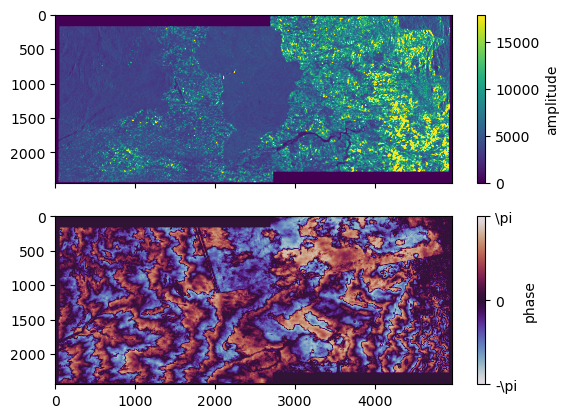

In [13]:
igram_amp = np.flip(np.abs(igram_arr), axis=1)
igram_phase = np.flip(np.angle(igram_arr), axis=1)
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
amp = ax[0].imshow(igram_amp, aspect="auto",vmin=np.percentile(igram_amp, 5), vmax=np.percentile(igram_amp, 95))
cb0 = fig.colorbar(amp, ax=ax[0], label='amplitude')

phase = ax[1].imshow(igram_phase, aspect="auto",vmin=-np.pi, vmax=np.pi, cmap="twilight")
cb1 = fig.colorbar(phase, ax=ax[1], label='phase')
cb1.set_ticks(ticks=[-np.pi, 0, np.pi], labels=[r'-\pi', 0, r'\pi'])


In [14]:
geo_igram_arr1.shape, geo_igram_arr.shape

((2700, 3500), (973, 1260))

/data/tapas/pearse/miniconda3/envs/gis/lib/python3.12/site-packages/numpy/ma/core.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.asarray(fill_value, dtype=ndtype)


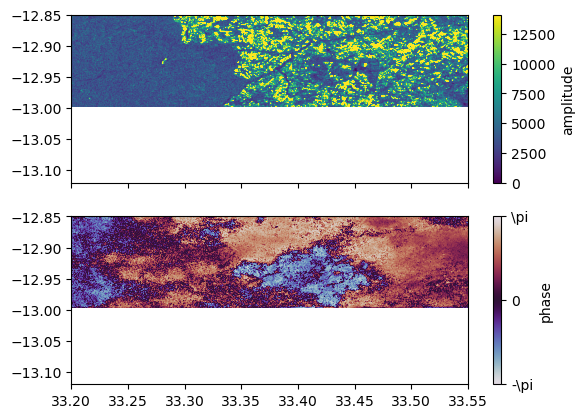

In [15]:
upper_left_x, delta_x, _, upper_left_y, _, delta_y = gds.GetGeoTransform()
extent = [upper_left_x, upper_left_x+delta_x*gds.RasterXSize, upper_left_y+delta_y*gds.RasterYSize, upper_left_y]

geo_igram_amp = np.abs(geo_igram_mask)
geo_igram_phase = np.angle(geo_igram_mask)
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
amp = ax[0].imshow(geo_igram_amp, origin="upper", aspect="auto", extent=extent, vmin=np.percentile(geo_igram_amp.data, 5), vmax=np.percentile(geo_igram_amp.data, 95))
cb0 = fig.colorbar(amp, ax=ax[0], label='amplitude')

phase = ax[1].imshow(geo_igram_phase, origin="upper", aspect="auto", extent=extent, vmin=-np.pi, vmax=np.pi, cmap="twilight")
cb1 = fig.colorbar(phase, ax=ax[1], label='phase')
cb1.set_ticks(ticks=[-np.pi, 0, np.pi], labels=[r'-\pi', 0, r'\pi'])


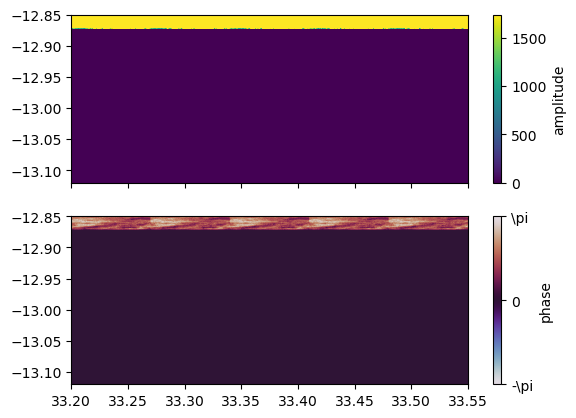

In [16]:
upper_left_x, delta_x, _, upper_left_y, _, delta_y = gds1.GetGeoTransform()
extent = [upper_left_x, upper_left_x+delta_x*gds1.RasterXSize, upper_left_y+delta_y*gds1.RasterYSize, upper_left_y]

geo_igram_amp = np.abs(geo_igram_arr1)
geo_igram_phase = np.angle(geo_igram_arr1)
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
amp = ax[0].imshow(geo_igram_amp, origin="upper", aspect="auto", extent=extent, vmin=np.percentile(geo_igram_amp.data, 5), vmax=np.percentile(geo_igram_amp.data, 95))
cb0 = fig.colorbar(amp, ax=ax[0], label='amplitude')

phase = ax[1].imshow(geo_igram_phase, origin="upper", aspect="auto", extent=extent, vmin=-np.pi, vmax=np.pi, cmap="twilight")
cb1 = fig.colorbar(phase, ax=ax[1], label='phase')
cb1.set_ticks(ticks=[-np.pi, 0, np.pi], labels=[r'-\pi', 0, r'\pi'])

In [17]:
np.percentile(b_amp.data,90)

NameError: name 'b_amp' is not defined

In [18]:
ds.RasterXSize, ds.RasterYSize

(4969, 2442)

In [19]:
src = rio.open(geocoded_igram)

In [20]:
from rasterio.plot import show

In [21]:
src.close()

In [22]:
geocoded_coherence = "/data/tapas/pearse/malawi/sentinel1/liwonde_stack/merged/interferograms/20230109_20230121/geo_filt_fine.cor"
gcoh_rio = rio.open(geocoded_coherence)

NameError: name 'gcoh_rio' is not defined

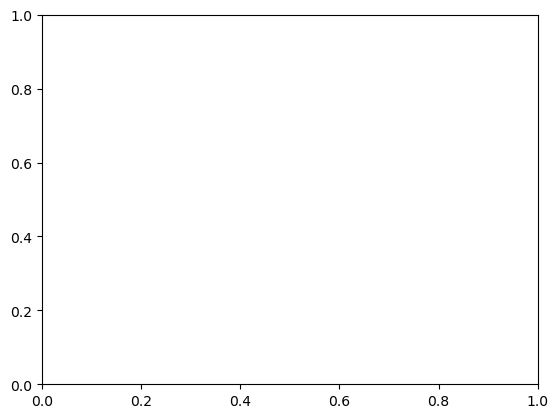

In [5]:
aoi_dir = Path("/data/tapas/pearse/malawi/sentinel1/aoi")
national_parks = aoi_dir/"protected_areas.json"
kasungu_aoi = aoi_dir/"kasungu_small.geojson"
npark = geojson_to_shapely(national_parks, 25)
bbox = geojson_to_shapely(kasungu_aoi)
park_bound = bbox & npark
outside_park = bbox ^ park_bound

fig, ax = plt.subplots(1,1)
show(gcoh_rio, ax=ax)
# ax.plot(*park_bound.exterior.xy, color='r')

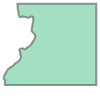

In [24]:
bbox ^ park_bound

In [25]:
out_image, out_transform = mask(gcoh_rio, [npark], crop=True)
out_meta = gcoh_rio.meta

ValueError: Input shapes do not overlap raster.

In [26]:
plt.figure()
plt.imshow(out_image[0])

NameError: name 'out_image' is not defined

<Figure size 640x480 with 0 Axes>

'{"type":"MultiPolygon","coordinates":[[[[33.019845,-12.666457],[33.020186,-12.662433],[33.020999,-12.658056],[33.021382,-12.655352],[33.02131,-12.651491],[33.023338,-12.648515],[33.026287,-12.646933],[33.029245,-12.644599],[33.031971,-12.642094],[33.03352,-12.639914],[33.03532,-12.63636],[33.036813,-12.633964],[33.03856,-12.629948],[33.039109,-12.628049],[33.040611,-12.624893],[33.042687,-12.622786],[33.044466,-12.621013],[33.047656,-12.61886],[33.048846,-12.617368],[33.050234,-12.613931],[33.05407,-12.611607],[33.057672,-12.609273],[33.059093,-12.608025],[33.060986,-12.606487],[33.063229,-12.605121],[33.064539,-12.603348],[33.067943,-12.602922],[33.071877,-12.602216],[33.073251,-12.599982],[33.075494,-12.598616],[33.07809,-12.597032],[33.08028,-12.595205],[33.08212,-12.593152],[33.084472,-12.592482],[33.086469,-12.592101],[33.089589,-12.590798],[33.092588,-12.589911],[33.095266,-12.591429],[33.097411,-12.593526],[33.098604,-12.596827],[33.099639,-12.598563],[33.10095,-12.601745],[33.

In [27]:
stats_inside = zonal_stats(park_bound, geocoded_coherence)
stats_outside = zonal_stats(outside_park, geocoded_coherence)
stats_inside[0], stats_outside

({'count': 0, 'min': None, 'max': None, 'mean': None},
 [{'count': 0, 'min': None, 'max': None, 'mean': None}])

In [28]:
def get_zonal_means(
        raster_file: str | Path,
        bbox: Polygon | MultiPolygon,
        npark: Polygon | MultiPolygon,
        ):

    inside_park = bbox & npark
    outside_park = bbox ^ inside_park
    zone_means = {"inside":0, "outside":0}
    for zone_poly, zone_name in zip([inside_park, outside_park], zone_means.keys()):
        stats = zonal_stats(zone_poly, raster_file)
        mean = stats[0]['mean']
        zone_means[zone_name] = mean

    return zone_means

In [29]:
zone_means = get_zonal_means(geocoded_coherence, bbox, npark)

In [30]:
zone_means

{'inside': None, 'outside': None}

In [31]:
merged_dir = Path("/data/tapas/pearse/malawi/sentinel1/kasungu_stack/merged/interferograms")
coherences = merged_dir.glob("*/geo_filt_fine.cor")
zone_means = {}
for coh in sorted(coherences):
    time_range = coh.parts[-2].split('_')[0]
    zone_means[time_range] = get_zonal_means(coh, bbox, npark)

In [32]:
zone_means

{'20230114': {'inside': 0.43581092267061117, 'outside': 0.609968799392104},
 '20230126': {'inside': 0.5372132732929583, 'outside': 0.6748256172066313},
 '20230207': {'inside': 0.5149220470920609, 'outside': 0.7328561312405861},
 '20230219': {'inside': 0.558416735832891, 'outside': 0.7511562705029965},
 '20230303': {'inside': 0.5859034274576828, 'outside': 0.6445793441152302},
 '20230315': {'inside': 0.545675145435085, 'outside': 0.658649055009321},
 '20230327': {'inside': 0.6803279260289088, 'outside': 0.7028620826383469},
 '20230408': {'inside': 0.6976991271104689, 'outside': 0.6095361968531483},
 '20230420': {'inside': 0.7421458357592665, 'outside': 0.5886081802207533},
 '20230502': {'inside': 0.8188868621624729, 'outside': 0.8107603442146928},
 '20230514': {'inside': 0.9376885484914447, 'outside': 0.8810514364009967},
 '20230526': {'inside': 0.9050391764190733, 'outside': 0.9133714066187334},
 '20230607': {'inside': 0.8747163750772423, 'outside': 0.92456770595843},
 '20230619': {'in

In [33]:
dts[0]

NameError: name 'dts' is not defined

In [34]:
root_path = Path("/data/tapas/pearse/malawi/")
ssm_path = root_path/"SSM/kasungu_1km_20230101_20240531"
shp_file = ssm_path/"sm_inversions_kasungu_1km_20230101_20240531_500.shp"
polygon_geojson = ssm_path/"kasungu_1km_20230101_20240531/INSAR4SM_processing/SM/SM_polygons.geojson"

gdf = load_ssm(shp_file, polygon_geojson)


<Axes: >

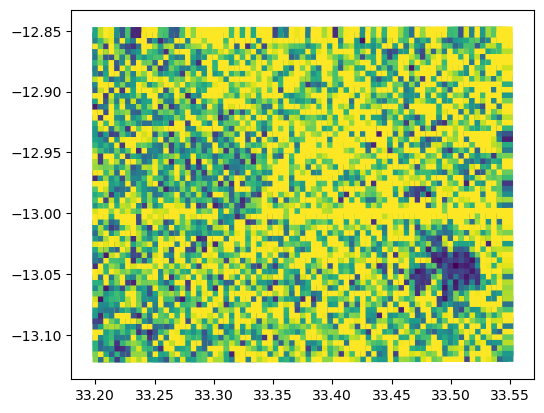

In [35]:
gdf.plot(gdf.columns[1])

In [18]:
liwonde_aoi = aoi_dir/"southern_malawi_aoi.geojson"
bbox = geojson_to_shapely(kasungu_aoi)
left, bottom, right, top = bbox.bounds
bbox.bounds

(33.2, -13.12, 33.55, -12.85)

In [19]:
a = np.abs(left-right)
b = np.abs(bottom-top)
a, b

(np.float64(0.3499999999999943), np.float64(0.2699999999999996))

In [2]:
R = 6371
def deg_to_km(deg):
    s = (np.pi*R*deg)/180
    return s
    

In [20]:
a = 115.35- 114.75
b = 33.8 - 33.5
a, b

(0.5999999999999943, 0.29999999999999716)

In [17]:
deg_to_km(a) * deg_to_km(b)

np.float64(1480.8303385940085)

In [21]:
deg_to_km(a) * deg_to_km(b)


2225.576108067942

In [39]:
df_datetimes = pd.to_datetime(gdf.columns[1:], format="D%Y%m%d")
gdf['intersects_park'] = gdf['geometry'].map(lambda x: x.intersects(npark))
gdfi = gdf.where(gdf['intersects_park']).dropna()
gdfo = gdf.where(~gdf['intersects_park']).dropna()


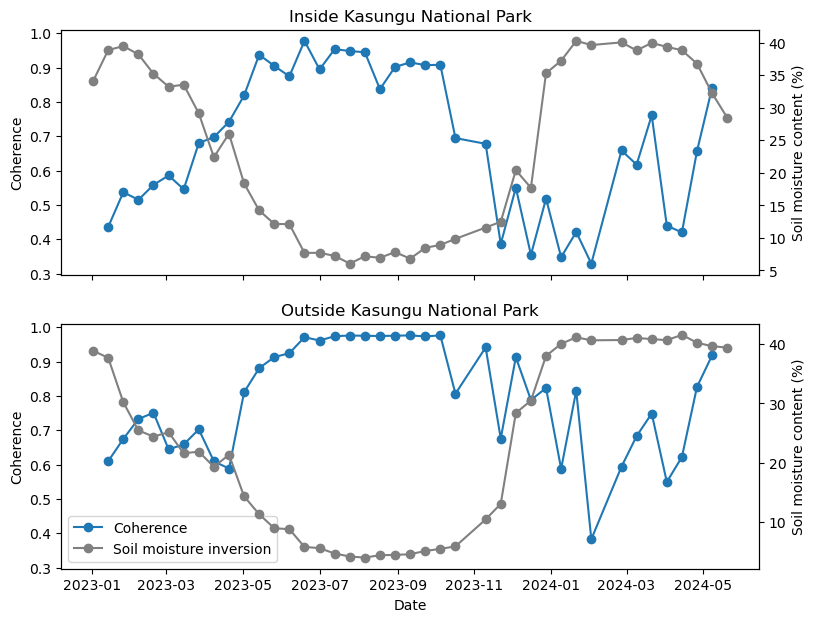

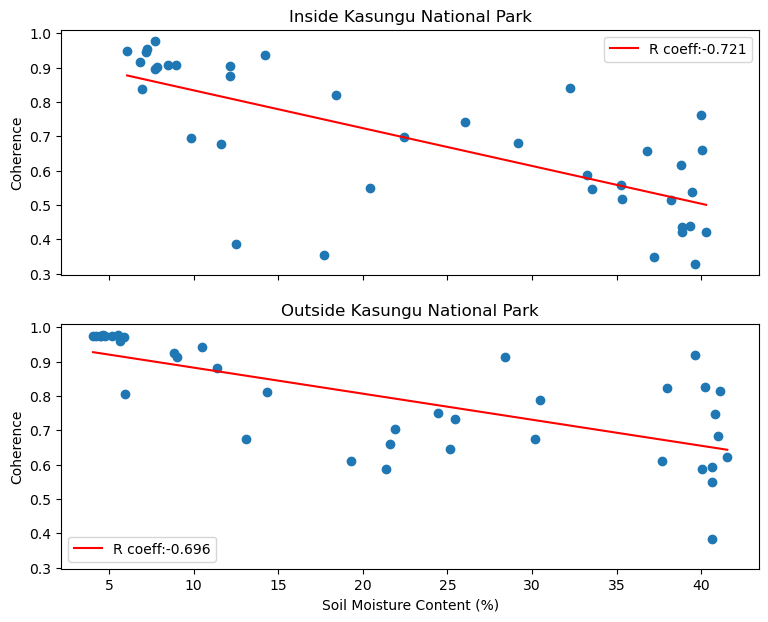

In [40]:

dts = [datetime.strptime(zm, "%Y%m%d") for zm in zone_means]
fig, ax1 = plt.subplots(2,1, figsize=(9,7), sharex=True, sharey=True)
fig_cor, ax1_cor = plt.subplots(2,1, figsize=(9,7), sharex=True, sharey=True)
outside_zone = [zone_means[zm]["outside"] for zm in zone_means]
i = 0
for gdf, zone in zip([gdfi, gdfo], ["inside", "outside"]):
    
    SSM_mean = gdf.mean(numeric_only=True)
    coh_mean = [zone_means[zm][zone] for zm in zone_means]

    coh_plot = ax1[i].plot(dts, coh_mean, '-o', label="Coherence")
    ax1[i].set_title(zone.capitalize()+ " Kasungu National Park")
    ax1[i].set_ylabel("Coherence")
    
    ax2 = ax1[i].twinx()
    smi = ax2.plot(
        df_datetimes,
        SSM_mean,
        'o-',
        color="grey",
        label="Soil moisture inversion")
    ax2.set_ylabel("Soil moisture content (%)")

    ax1_cor[i].plot(SSM_mean[1:-1], coh_mean, 'o')
    best_fit_params = linregress(SSM_mean[1:-1], coh_mean)
    x = np.linspace(np.min(SSM_mean[1:-1]), np.max(SSM_mean[1:-1]), 100)
    best_fit = best_fit_params.slope*x + best_fit_params.intercept
    ax1_cor[i].plot(x, best_fit, 'red', label=f"R coeff:{np.round(best_fit_params.rvalue, 3)}")
    ax1_cor[i].set_ylabel("Coherence")
    ax1_cor[i].set_title(zone.capitalize()+ " Kasungu National Park")
    ax1_cor[i].legend()
    # ax1_cor[i].text(10, 0.4, f"R coeff:{np.round(best_fit_params.rvalue, 3)}")
    i+=1
handles = coh_plot + smi
labels = [label.get_label() for label in handles]
ax1[1].legend(handles, labels,)# loc=(0.25, 0.8))
ax1[1].set_xlabel("Date")
ax1_cor[1].set_xlabel("Soil Moisture Content (%)")
fig.savefig("/data/tapas/pearse/malawi/Coherence_and_SSM.png")
fig_cor.savefig("/data/tapas/pearse/malawi/SSM_coherence_cor.png")

In [41]:
lbbox.bounds

NameError: name 'lbbox' is not defined

In [42]:
plt.close("all")

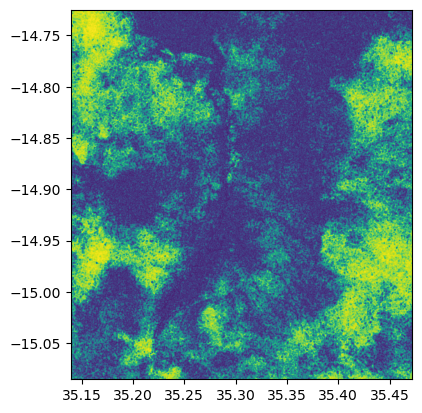

<Axes: >

In [43]:
plt.figure()
show(gcoh_rio)

In [44]:
liwonde_aoi = aoi_dir/"southern_malawi_aoi.geojson"
lbbox = geojson_to_shapely(liwonde_aoi)

In [45]:
lbbox.bounds

(35.1398, -15.0851, 35.4723, -14.7249)

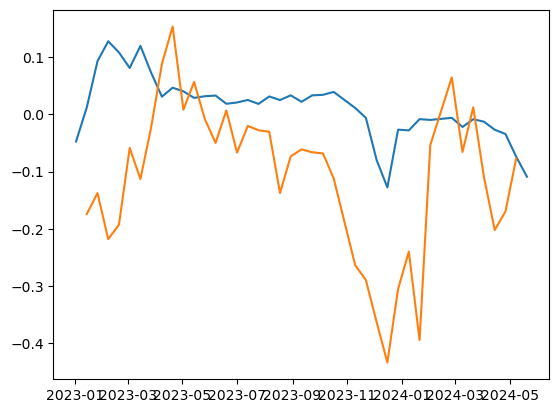

In [46]:
SSM_mean_diff = gdfi.mean(numeric_only=True)/100 - gdfo.mean(numeric_only=True)/100
coh_mean_diff = np.array([zone_means[zm]["inside"] for zm in zone_means]) - np.array([zone_means[zm]["outside"] for zm in zone_means])
plt.figure()
plt.plot(df_datetimes, SSM_mean_diff)
plt.plot(dts, coh_mean_diff)
# plt.figure()
# plt.plot(SSM_mean[1:-1], coh_mean_diff, 'o' )

<Axes: >

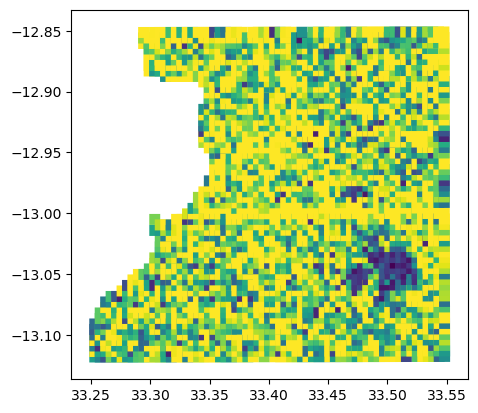

In [47]:
gdf['intersects_park'] = gdf['geometry'].map(lambda x: x.intersects(npark))
# gdfi = gdf.where(gdf['intersects_park']).dropna()
gdfo.plot("D20230102")